# Clinical Trial Optimization 

### Problem Presentation

This competition organized by Ingenii focused on optimizing subject sorting for a clinical trial. The full problem description is available on [the Aqora platform](https://aqora.io/competitions/ingenii-clinical-trial), which hosts the competition.

The task involves grouping subjects based on certain parameters during a clinical trial. The goal is to ensure that, after forming the groups, the subjects within the same group are suited for the clinical tests they will undergo.

### Mathematical Formulation

We have 100 subjects that we wish to divide into two groups \( p = \{1, 2\} \) with 50 people each. Each subject \( i \) is characterized by 3 parameters \( \vec{w_i} = (w_{i1}, w_{i2}, w_{i3}) \). The quality of this partition is measured by the following quantity:

$$
d = \sum_{s=1}^{3} |\Delta\mu_s| + \rho \sum_{s=1}^{3} |\Delta\sigma_{ss}| + 2\rho \sum_{s=1}^{3} \sum_{s' = s+1}^{3} |\Delta\sigma_{ss'}|
$$

where:

$$
\Delta\mu_s = \frac{1}{n} \sum_{i=1}^{n} w_{is}(x_{i1} - x_{i2})
$$

and:

$$
\Delta\sigma_{ss'} = \frac{1}{n} \sum_{i=1}^{n} w_{is} w_{is'} (x_{i1} - x_{i2})
$$

Here, \( x_{ip} \) is a binary variable that is 1 if subject \( i \) belongs to group \( p \), and 0 otherwise.

The quantity \( d \) is called the *discrepancy*. For an ideal grouping, the *discrepancy* is minimized. This grouping problem thus boils down to solving the following optimization problem:

$$
\min_{x} d
$$

under the constraints:

$$
\sum_{i}x_{ip} = \frac{n}{2}, \quad \text{Each group contains the same number of subjects.}
$$

$$
x_{i1} + x_{i2} = 1, \quad \text{A subject can belong to only one group after the partitioning.}
$$

$$
x_{12} = 0, \quad \text{This is to avoid redundancy of solutions, as the same partition is obtained by swapping groups 1 and 2.}
$$

To solve this problem, I use the QAOA (Quantum Approximate Optimization Algorithm), which allows finding the minimum or maximum of a quadratic function. The first issue we encounter is that we cannot directly implement \( d \) due to the absolute value. Therefore, we will first reformulate the problem to make it suitable for implementation with the QAOA algorithm.

### Reformulation of the problem

* **Writing without absolute values:**
$$ a = |x| \Rightarrow x \leq a \text{ and } -x \leq a$$

We then define $z_s = |\Delta\mu_s|$, $z_{ss} = |\Delta\sigma_{ss}|$, and $z_{ss'} = |\Delta\sigma_{ss'}|$. The new formulation becomes:
$$
\min_{x, z} \sum_{s=1}^{3} z_s + \rho \sum_{s=1}^{3} z_{ss} + 2\rho \sum_{s=1}^{3} \sum_{s' = s+1}^{3} z_{ss'}
$$
subject to the following constraints:
$$
\sum_{i} x_{ip} = \frac{n}{2}, \quad \text{each group contains the same number of subjects.}
$$
$$
x_{i1} + x_{i2} = 1, \quad \text{a subject can belong to only one group after clustering.}
$$
$$
x_{12} = 0, \quad \text{this prevents redundant solutions, as switching groups 1 and 2 would result in the same clustering.}
$$
$$
\Delta\mu_s \leq z_s \text{ and } -\Delta\mu_s \leq z_s
$$
$$
\Delta\sigma_{ss} \leq z_{ss} \text{ and } -\Delta\sigma_{ss} \leq z_{ss}
$$
$$
\Delta\sigma_{ss'} \leq z_{ss'} \text{ and } -\Delta\sigma_{ss'} \leq z_{ss'}
$$

* **Reduction of the number of variables:**

By replacing the constraint $x_{i1} + x_{i2} = 1$ in the problem, we reduce the number of variables by $n$. After adding the variables $z$, we end up with $n - 1 + 9$, which gives $n + 8$ variables.

## Implementation
At this stage, the problem is well-defined to be implemented with the QAOA algorithm. The next step is to transform it into a QUBO problem.

In [264]:
n = 2  # number of subjects
N = 1  # we remove the division by 1 in the objective function
rho = 0.5


In [265]:
# importation of data of each subject
import csv
import numpy as np

data_list_csv = []
with open('pbc.csv', mode='r') as file:
    reader = csv.reader(file)
    # Skip the header
    next(reader)
    # Iterate over the rows and add them to the list
    for row in reader:
        # Convert strings to float for numeric columns
        data_list_csv.append([float(row[0]), float(row[1]), float(row[2])])

max_values = np.max(data_list_csv , axis=0)
data_list_frmt = data_list_csv

In [266]:
print(data_list_frmt[:10])

[[12.2, 58.7652292950034, 1718.0], [10.6, 56.4462696783025, 7394.8], [12.0, 70.072553045859, 516.0], [10.3, 54.7405886379192, 6121.8], [10.9, 38.1054072553046, 671.0], [11.0, 66.258726899384, 944.0], [9.7, 55.5345653661875, 824.0], [11.0, 53.056810403833, 4651.2], [11.0, 42.507871321013, 2276.0], [11.5, 70.5598904859685, 918.0]]


In [267]:
# creation of quadratic problem
from qiskit_optimization import QuadraticProgram
mod = QuadraticProgram("Clinical trial Optimization")

for i in range(1, n + 1):
    var_name = f"x_{i}1"
    mod.binary_var(name=var_name)

# Integer variables
W = []
for i in range(3):
    w_list = [row[i] for row in data_list_frmt]
    w_sum = 0
    for w in w_list:
        w_sum = w_sum + w  # Sum of w
    W.append(w_sum)

mod.integer_var(name= "z_1", lowerbound=0, upperbound=int(W[0]) + 1)
mod.integer_var(name= "z_2", lowerbound=0, upperbound=int(W[1]) + 1)
mod.integer_var(name= "z_3", lowerbound=0, upperbound=int(W[2]) + 1)

W_square = []
for i in range(3):
    w_list = [row[i] for row in data_list_frmt]
    w_sum = 0
    for w in w_list:
        w_sum = w_sum + w**2  # Sum of w squared
    W_square.append(w_sum)

mod.integer_var(name= "z_11", lowerbound=0, upperbound=int(W_square[0]) + 1)
mod.integer_var(name= "z_22", lowerbound=0, upperbound=int(W_square[1]) + 1)
mod.integer_var(name= "z_33", lowerbound=0, upperbound=int(W_square[2]) + 1)

W_cross = []
for i in range(3):
    w_list_s = [row[i] for row in data_list_frmt]
    for k in range(i + 1, 3):
        w_sum = 0
        w_list_s_prime = [row[k] for row in data_list_frmt]
        for w_i, w_k in zip(w_list_s, w_list_s_prime):
            w_sum = w_sum + w_i * w_k  # Sum of cross products
        W_cross.append(w_sum)

mod.integer_var(name= "z_12", lowerbound=0, upperbound=int(W_cross[0] + 1))
mod.integer_var(name= "z_13", lowerbound=0, upperbound=int(W_cross[1] + 1))
mod.integer_var(name= "z_23", lowerbound=0, upperbound=int(W_cross[2] + 1))


<Variable: 0 <= z_23 <= 30608403 (integer)>

In [268]:
# definition of the objective function
mod.minimize(linear={"z_1": 1 ,"z_2": 1 , "z_3": 1 
                      , "z_11":0.5 , "z_22":0.5 , "z_33":0.5
                      , "z_12":1 , "z_13":1 , "z_23":1})

## The constraints
Now we implément the constraints unders objective function we have 

In [269]:
# somme of x_i1 should be equal to n/2
dict_som = {f"x_{i}1": 1 for i in range(1 , n + 1)}
mod.linear_constraint(dict_som , sense= "==" , rhs = n/2 , name = "repartition egale")

#x_11 = 1
mod.linear_constraint({"x_11": 1} , sense= "==" , rhs = 1 , name= "avoid redundance")

<LinearConstraint: x_11 == 1 'avoid redundance'>

Constraints: $\Delta\mu_s \leq z_s \text{ et } -\Delta\mu_s \leq z_s$

$$
\Delta\mu_s \leq z_s  \Rightarrow \sum_{i = 1}^{n}2w_{is}x_{i1} - nz_{s} \leq \sum_{i = 1}^{n}w_{is} \\

-\Delta\mu_s \leq z_s \Rightarrow \sum_{i = 1}^{n}2w_{is}x_{i1} + nz_{s} \geq \sum_{i = 1}^{n}w_{is} 
$$



In [270]:
for i in range(3):
    dict_x_s = {}
    w_list = [row[i] for row in data_list_frmt]

    # Multiply the entire equation by 100 to have only integer coefficients
    dict_x_s = {f"x_{j + 1}1": int(round(2*w_list[j] , 2)*100)  for j in range(0 , n)} 
    dict_x_s.update({f"z_{i + 1}": -n * 100})
    mod.linear_constraint(linear=dict_x_s , sense= "<=" , rhs= int(round(W[i] , 2)*100))
    

for i in range(3):
    dict_x_s = {}
    w_list = [row[i] for row in data_list_frmt]
    dict_x_s = {f"x_{j + 1}1": int(round(2*w_list[j])*100)  for j in range(0 , n)}
    dict_x_s.update({f"z_{i + 1}": n*100})
    mod.linear_constraint(linear=dict_x_s , sense= ">=" , rhs= int(round(W[i] , 2)*100))


Constraints: $\Delta\sigma_{ss} \leq z_{ss} \text{ et } -\Delta\sigma_{ss} \leq z_{ss}$

$$
\Delta\sigma_{ss} \leq z_{ss} \Rightarrow \sum_{i = 1}^{n}2w_{is}^2x_{i1} - nz_{ss}  \leq \sum_{i = 1}^{n}w_{is}^2 \\

- \Delta\sigma_{ss} \leq z_{ss} \Rightarrow \sum_{i = 1}^{n}2w_{is}^2x_{i1} + nz_{ss}  \geq \sum_{i = 1}^{n}w_{is}^2 
$$

In [271]:
for i in range(3):
    dict_x_s = {}
    w_list = [row[i] for row in data_list_frmt]
    dict_x_s = {f"x_{j + 1}1": int(round(2*(w_list[j]**2),2)*100) for j in range(0 , n)}
    dict_x_s.update({f"z_{i + 1}" + f"{i + 1}": -n*100})
    mod.linear_constraint(linear=dict_x_s , sense= "<=" , rhs= int(round(W_square[i],2)*100))
   


for i in range(3):
    dict_x_s = {}
    w_list = [row[i] for row in data_list_frmt]
    dict_x_s = {f"x_{j + 1}1": int(round(2*(w_list[j]**2),2)*100) for j in range(0 , n)}
    dict_x_s.update({f"z_{i + 1}" + f"{i + 1}": n*100})
    mod.linear_constraint(linear=dict_x_s , sense= ">=" , rhs= int(round(W_square[i] , 2)*100))
    

Constaints: $\Delta\sigma_{ss'} \leq z_{ss'} \text{ et } -\Delta\sigma_{ss'} \leq z_{ss'}$

$$
\Delta\sigma_{ss'} \leq z_{ss'} \Rightarrow \sum_{i = 1}^{n}2w_{is}w_{is'}x_{i1} - nz_{ss'}  \leq \sum_{i = 1}^{n}w_{is}w_{is'} \\

- \Delta\sigma_{ss'} \leq z_{ss'} \Rightarrow \sum_{i = 1}^{n}2w_{is}w_{is'}x_{i1} + nz_{ss'}  \geq \sum_{i = 1}^{n}w_{is}w_{is'} 
$$

In [272]:
for i in range(3):
    w_list_s = [row[i] for row in data_list_frmt]
    for k in range(i + 1 , 3):
        dict_x_s = {}
        w_list_s_prime = [row[k] for row in data_list_frmt]
        dict_x_s = {f"x_{j + 1}1": int(round(2*(w_list_s[j]*w_list_s_prime[j]) , 2)*100) for j in range(0 , n)}
        dict_x_s.update({f"z_{i + 1}" + f"{k + 1}": -n*100})
        mod.linear_constraint(linear=dict_x_s , sense= "<=" , rhs= int(round(W_cross[i] , 2)*100))
        


for i in range(3):
    w_list_s = [row[i] for row in data_list_frmt]
    for k in range(i + 1 , 3):
        dict_x_s = {}
        w_list_s_prime = [row[k] for row in data_list_frmt]
        dict_x_s = {f"x_{j + 1}1": int(round(2*(w_list_s[j]*w_list_s_prime[j]) , 2)*100) for j in range(0 , n)}
        dict_x_s.update({f"z_{i + 1}" + f"{k + 1}": n*100})
        mod.linear_constraint(linear=dict_x_s , sense= ">=" , rhs= int(round(W_cross[i],2)*100))

In [273]:
print(mod.prettyprint())

Problem name: Clinical trial Optimization

Minimize
  z_1 + 0.5*z_11 + z_12 + z_13 + z_2 + 0.5*z_22 + z_23 + z_3 + 0.5*z_33

Subject to
  Linear constraints (20)
    x_11 + x_21 == 1  'repartition egale'
    x_11 == 1  'avoid redundance'
    2440*x_11 + 2120*x_21 - 200*z_1 <= 334640  'c2'
    11753*x_11 + 11289*x_21 - 200*z_2 <= 1560593  'c3'
    343600*x_11 + 1478960*x_21 - 200*z_3 <= 61858860  'c4'
    2400*x_11 + 2100*x_21 + 200*z_1 >= 334640  'c5'
    11800*x_11 + 11300*x_21 + 200*z_2 >= 1560593  'c6'
    343600*x_11 + 1479000*x_21 + 200*z_3 >= 61858860  'c7'
    29768*x_11 + 22472*x_21 - 200*z_11 <= 3620598  'c8'
    690670*x_11 + 637236*x_21 - 200*z_22 <= 81541365  'c9'
    590304800*x_11 + 10936613408.0*x_21 - 200*z_33 <= 265122146004  'c10'
    29768*x_11 + 22472*x_21 + 200*z_11 >= 3620598  'c11'
    690670*x_11 + 637236*x_21 + 200*z_22 >= 81541365  'c12'
    590304800*x_11 + 10936613408.0*x_21 + 200*z_33 >= 265122146004  'c13'
    143387*x_11 + 119666*x_21 - 200*z_12 <= 168032

## Transformation to QUBO

The quantum problem with constraints is well-defined. Now we will transform it into a constrained quadratic problem using the `QuadraticProgramToQubo` method.

In [274]:
from qiskit_optimization.converters import QuadraticProgramToQubo

cto_qubo = QuadraticProgramToQubo().convert(mod)
#print(cto_qubo.prettyprint())

### Mapping into Ising Problem

When transforming a quadratic problem into QUBO (Quadratic Unconstrained Binary Optimization), one realizes the exponentially high number of additional binary variables required for this conversion. This is due to the inequality constraints. Indeed, for a constraint of the form  $a_0x_0 + ... + a_nx_n \leq S$, it requires $\log_{2}(S) + 1$ additional binary variables to convert it into an equality constraint.

In our case, the right-hand sides of the inequality constraints are at least on the order of $10^5$, which necessitates at least 18 additional variables per equation. With 18 equations, this represents at least 324 additional variables, making the problem practically intractable.

Thus, due to the absolute value formulation, the data involved in this problem, and the formatting constraints imposed by the Qiskit library, a direct approach to solving this problem becomes unfeasible.

We will try a different approach. Instead of finding the minimum of $d $, we will look for the minimum of 

$$
d' = \sum_{s=1}^{3} (\Delta\mu_s)^2 + \rho \sum_{s=1}^{3} (\Delta\sigma_{ss})^2 + 2\rho \sum_{s=1}^{3} \sum_{s' = s+1}^{3} (\Delta\sigma_{ss'})^2
$$

subject to the same constraints as $ d $. I am working with $ d' $ under the assumption that $d$ and $d'$ reach their minimum for the same $ x$ or at least for close values of $x$. The examples below show that $d$ and $d'$ do indeed reach their minimum for the same bit string.

In [ ]:
def objective_func_square(x_list  , n):
    d_prime = 0
    d_1 =0
    d_2 = 0
    d_3 = 0
    for s in range(3):
        w = 0
        for i in range(n):
            w = w + data_list_frmt[i][s]*(2*x_list[i] - 1)
        w = (w/n)**2
        d_1 = d_1 + w

    for s in range(3):
        w = 0
        for i in range(n):
            w = w + (data_list_frmt[i][s]**2)*(2*x_list[i] - 1)
        w = (w/n)**2
        d_2 = d_2 + w
    d_2 = rho*d_2

    for s in range(3):
        for s_p in range(s , 3):
            w = 0
            for i in range(n):
                w = w + (data_list_frmt[i][s]*data_list_frmt[i][s_p])*(2*x_list[i] - 1)
            w = (w/n)**2
            d_3 = d_3 + w
    d_3 = 2*rho*d_2

    d_prime = d_1 + d_2 + d_3
    return d_prime
    

def objective_func(x_list  , n):
    d = 0
    d_1 =0
    d_2 = 0
    d_3 = 0
    for s in range(3):
        w = 0
        for i in range(n):
            w = w + data_list_frmt[i][s]*(2*x_list[i] - 1)
        w = np.abs(w/n)
        d_1 = d_1 + w

    for s in range(3):
        w = 0
        for i in range(n):
            w = w + (data_list_frmt[i][s]**2)*(2*x_list[i] - 1)
        w = np.abs(w/n)
        d_2 = d_2 + w
    d_2 = rho*d_2

    for s in range(3):
        for s_p in range(s , 3):
            w = 0
            for i in range(n):
                w = w + (data_list_frmt[i][s]*data_list_frmt[i][s_p])*(2*x_list[i] - 1)
            w = np.abs(w/n)
            d_3 = d_3 + w
    d_3 = 2*rho*d_2

    d = d_1 + d_3 + d_3
    return d



import itertools
list_test = [2, 4, 6, 10, 12, 14, 16, 18]

# Loop over different values of M
for M in list_test:
    poss_list = list(itertools.product([0, 1], repeat=M))  # List of all binary combinations
    d_min = 1e20  # Initialization of the minimum value for the first function
    d_min_square = 1e20  # Initialization of the minimum value for the second function
    best_x = None  # To store the best solution for the first function
    best_x_square = None  # To store the best solution for the second function

    # Loop over all possible binary combinations
    for x in poss_list:
        if sum(x) == M / 2:  # Condition on the sum of elements in x
            if x[0] == 1:  # Condition on the first element of x
                # Calculate the values of the functions
                d = objective_func(x, M)
                d_square = objective_func_square(x, M)

                # Update the best value for the first function
                if d < d_min:
                    d_min = d
                    best_x = x

                # Update the best value for the second function
                if d_square < d_min_square:
                    d_min_square = d_square
                    best_x_square = x

    # Display the results
    print(f"M = {M}:")
    print(f"Minimum value (func1, func2): ({d_min}, {d_min_square})")
    print(f"Best x (func1, func2): ({best_x}, {best_x_square})")
    print("-" * 50)


    

M = 2:
Minimum value (func1, func2): (25868763.704886556, 669038144399537.5)
Best x (func1, func2): ((1, 0), (1, 0))
--------------------------------------------------
M = 4:
Minimum value (func1, func2): (3630773.9507093076, 13179375582999.545)
Best x (func1, func2): ((1, 0, 0, 1), (1, 0, 0, 1))
--------------------------------------------------
M = 6:
Minimum value (func1, func2): (2346996.4062184403, 5507211203816.434)
Best x (func1, func2): ((1, 0, 0, 1, 0, 1), (1, 0, 0, 1, 0, 1))
--------------------------------------------------
M = 10:
Minimum value (func1, func2): (50525.60581048776, 2520478540.747118)
Best x (func1, func2): ((1, 0, 1, 1, 1, 0, 0, 1, 0, 0), (1, 0, 1, 1, 1, 0, 0, 1, 0, 0))
--------------------------------------------------
M = 12:
Minimum value (func1, func2): (7768.342184312127, 56255086.06204513)
Best x (func1, func2): ((1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1), (1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1))
--------------------------------------------------
M = 14:
Minimum

To implement this new quadratic function $d'$, we need to calculate the coefficients of the linear terms $x_{i1}$ and the quadratic terms $x_{i1}x_{j1}$.

$$
(\Delta\mu_s)^2 = \frac{1}{n^2} \left( \sum_{j = 1}^{n}\sum_{i = 1}^{n} w_{js}w_{is}(4x_{j1}x_{i1} - 2x_{j1} - 2x_{i1} + 1) \right) = \frac{4}{n^2}\sum_{j = 1}^{n}\sum_{i = 1}^{n}w_{js}w_{is}x_{j1}x_{i1} - \frac{4}{n^2}\sum_{j = 1}^{n}\sum_{i = 1}^{n}w_{js}w_{is}x_{i1} + \frac{1}{n^2}\sum_{j = 1}^{n}\sum_{i = 1}^{n}w_{js}w_{is}
$$

$$
(\Delta\sigma_{ss})^{2} = \frac{4}{n^2}\sum_{j = 1}^{n}\sum_{i = 1}^{n}w_{js}^2w_{is}^2x_{j1}x_{i1} - \frac{4}{n^2}\sum_{j = 1}^{n}\sum_{i = 1}^{n}w_{js}^2w_{is}^2x_{i1} + \frac{1}{n^2}\sum_{j = 1}^{n}\sum_{i = 1}^{n}w_{js}^2w_{is}^2
$$

$$
(\Delta\sigma_{ss'})^{2} = \frac{4}{n^2}\sum_{j = 1}^{n}\sum_{i = 1}^{n}w_{js}w_{js'}w_{is}w_{is'}x_{j1}x_{i1} - \frac{4}{n^2}\sum_{j = 1}^{n}\sum_{i = 1}^{n}w_{js}w_{js'}w_{is}w_{is'}x_{i1} + \frac{1}{n^2}\sum_{j = 1}^{n}\sum_{i = 1}^{n}w_{js}w_{js'}w_{is}w_{is'}
$$


In [240]:
variable_name = [f"x_{i + 1}1" for i in range(n)]
mod_square = QuadraticProgram("Clinical trial Optimization")

for i in range(1 , n + 1):
    var_name = f"x_{i}1"
    mod_square.binary_var(name=var_name)

# DELTA MU_s contribution
# quadratic term
coef_quad_1 = [] # list of coefficients of the quadratic term of delta mu
dict_quad_1 = {} # dictionary of quadratic terms and their values
for i in range(n):
    for j in range(n):
            l = 0
            for s in range(3):
                 l = l + data_list_frmt[i][s]*data_list_frmt[j][s]
            coef_quad_1.append(l)

coef_quad_1 = [ coef*(4/(n*n)) for coef in coef_quad_1]

dict_quad_1 = { (variable_name[i], variable_name[j]): None 
                 for i in range(n) for j in range(n)}
dict_quad_1 = {key: coef_quad_1[i] for i, key in enumerate(dict_quad_1.keys())}

# linear term
coef_lin_1 = [] # list of linear coefficients of delta mu
dict_lin_1 = {} # dictionary of linear terms of delta mu and their coefficients
for i in range(n):
    sub_sum_2 = 0
    for s in range(3):
        sub_sum = 0
        for j in range(n):
            sub_sum = sub_sum + data_list_frmt[j][s]

        sub_sum_2 = sub_sum_2 + sub_sum*data_list_frmt[i][s]

    coef_lin_1.append(sub_sum_2)
coef_lin_1 = [coef*(-4/(n**2)) for coef in coef_lin_1]    

dict_lin_1 = {variable_name[i]: coef_lin_1[i] for i in range(len(variable_name))}

coef_const_1 = [] # list of constants of delta mu 
const_1 = 0 # sum of the constants of delta mu
coef_const_1 = [coef*(1/4) for coef in coef_quad_1] 
const_1 = sum(coef_const_1)


# (SIGMA_ss)^2 contribution
# quadratic term
coef_quad_2 = [] # list of coefficients of the quadratic term of sigma_ss
dict_quad_2 = {} # dictionary of quadratic terms of sigma_ss and their values 
for i in range(n):
    for j in range(n):
            l = 0
            for s in range(3):
                 l = l + rho*(data_list_frmt[i][s]**2)*(data_list_frmt[j][s]**2)
            coef_quad_2.append(l)

coef_quad_2 = [ coef*(4/(n*n)) for coef in coef_quad_1]

dict_quad_2 = { (variable_name[i], variable_name[j]): None 
                 for i in range(n) for j in range(n)}
dict_quad_2 = {key: coef_quad_2[i] for i, key in enumerate(dict_quad_2.keys())}

# linear terms
coef_lin_2 = [] # list of linear coefficients of sigma_ss
dict_lin_2 = {} # dictionary of linear terms of sigma_ss and their coefficients
for i in range(n):
    for s in range(3):
        sub_sum = 0
        sub_sum_2 = 0
        for j in range(n):
            sub_sum = sub_sum + rho*(data_list_frmt[j][s]**2)

        sub_sum = sub_sum*(data_list_frmt[i][s]**2)
        sub_sum_2 = sub_sum_2 + sub_sum
    coef_lin_2.append(sub_sum_2)
coef_lin_2 = [coef*(-4/(n**2)) for coef in coef_lin_2]    

dict_lin_2 = {variable_name[i]: coef_lin_2[i] for i in range(len(variable_name))}

# constant term
coef_const_2 = [] # list of constants of sigma_ss 
const_2 = 0 # sum of the constants of sigma_ss
coef_const_2 = [coef*(1/4) for coef in coef_quad_2] 
const_2 = sum(coef_const_2)



# (SIGMA_ss')^2 contribution
# quadratic terms
coef_quad_3 = [] # list of coefficients of the quadratic term of sigma_ss
dict_quad_3 = {} # dictionary of quadratic terms of sigma_ss and their values 
for i in range(n):
    for j in range(n):
            l = 0
            for s in range(3):
                 for s_p in range(s , 3):
                    l = l + 2*rho*(data_list_frmt[i][s]*data_list_frmt[i][s_p])*(data_list_frmt[j][s]*data_list_frmt[j][s_p])
            coef_quad_3.append(l)

coef_quad_3 = [ coef*(4/(n*n)) for coef in coef_quad_3]

dict_quad_3 = { (variable_name[i], variable_name[j]): None 
                 for i in range(n) for j in range(n)}
dict_quad_3 = {key: coef_quad_3[i] for i, key in enumerate(dict_quad_3.keys())}


# linear terms
coef_lin_3 = [] # list of linear coefficients of sigma_ss'
dict_lin_3 = {} # dictionary of linear terms of sigma_ss' and their coefficients
for i in range(n):
    for s in range(3):
        for s_p in range(s , 3):
            sub_sum = 0
            sub_sum_2 = 0
            for j in range(n):
                sub_sum = sub_sum + (data_list_frmt[j][s]*data_list_frmt[j][s_p])

            sub_sum = 2*rho* sub_sum*(data_list_frmt[i][s]*data_list_frmt[i][s_p])
            sub_sum_2 = sub_sum_2 + sub_sum
    coef_lin_3.append(sub_sum_2)
coef_lin_3 = [coef*(-4/(n**2)) for coef in coef_lin_3]    

dict_lin_3 = {variable_name[i]: coef_lin_3[i] for i in range(len(variable_name))}

# constant term
coef_const_3 = [] # list of constants of sigma_ss' 
const_3 = 0 # sum of the constants of sigma_ss'
coef_const_3 = [coef*(1/4) for coef in coef_quad_3] 
const_3 = sum(coef_const_3)




# Summation of the linear coefficients of each term delta, sigma_ss, and sigma_ss'
lin_dict = [dict_lin_1 , dict_lin_2 , dict_lin_3]
lin = {}
for d in lin_dict:
    for key , value in d.items():
        lin[key] = lin.get(key,0) + (value/1e15)

# Summation of the quadratic coefficients
lin_quad = [dict_quad_1 , dict_quad_2 , dict_quad_3]
quad = {}
for d in lin_quad:
    for key , value in d.items():
        quad[key] = quad.get(key,0) + (value/1e15)

# summation of the constants:
C = (const_1 + const_2 + const_3)/(1e15)


In [241]:
# definition of the quadratic problem
mod_square.minimize(constant= C , linear= lin , quadratic= quad)

In [242]:
# adding constrainte
dict_som = {f"x_{i}1": 1 for i in range(1 , n + 1)}
mod_square.linear_constraint(dict_som , sense= "==" , rhs = n/2 , name = "repartition egale") # somme des x_i = n/2
mod_square.linear_constraint({"x_11": 1} , sense= "==" , rhs = 1 , name= "avoid redundance") # x_11 = 1


<LinearConstraint: x_11 == 1 'avoid redundance'>

In [243]:
print(mod_square.prettyprint())

Problem name: Clinical trial Optimization

Minimize
  0.008722144251274357*x_11^2 + 0.32288441116870736*x_11*x_21
  + 2.990418315154597*x_21^2 - 0.25516483368995646*x_11
  - 4.7274543758890335*x_21 + 0.8305062176436446

Subject to
  Linear constraints (2)
    x_11 + x_21 == 1  'repartition egale'
    x_11 == 1  'avoid redundance'

  Binary variables (2)
    x_11 x_21



### Transformation to QUBO problem

In [244]:
cto_square_qubo = QuadraticProgramToQubo().convert(mod_square)
print(cto_square_qubo.prettyprint())

Problem name: Clinical trial Optimization

Minimize
  18.61801030455841*x_11^2 + 18.932172571475846*x_11*x_21
  + 12.295062395308166*x_21^2 - 37.473741154304236*x_11 - 23.33674253619617*x_21
  + 19.439794377950783

Subject to
  No constraints

  Binary variables (2)
    x_11 x_21



In [245]:
# Get Ising Hamiltonian
ising_hamiltonian , offset = cto_square_qubo.to_ising()
print("Offset:", offset)
print("Ising Hamiltonian:")
print(str(ising_hamiltonian))

Offset: 9.22413202550283
Ising Hamiltonian:
SparsePauliOp(['IZ', 'ZI', 'ZZ'],
              coeffs=[4.69482228+0.j, 0.78779693+0.j, 4.73304314+0.j])


# Searching for the Ground State of the Ising Hamiltonian

This part of the code is inspired by the tutorial [Solve utility-scale quantum optimization problems](https://learning.quantum.ibm.com/tutorial/quantum-approximate-optimization-algorithm) and follows these steps:

* Creation of a parameterized circuit from the Hamiltonian of the problem using QAOAAnsatz()
* Conversion of this circuit into a format suitable for the computer on which it will run, using the pass manager
* Optimization of the parameters of this circuit
* Execution of the circuit with the optimized parameters on the quantum computer.

I haven't exactly worked on a quantum computer due to access time limitations but rather on a simulator that simulates the behavior of a quantum computer.

In [246]:
from qiskit import QuantumCircuit
from qiskit.quantum_info import Pauli, Operator

# Define an XY mixer for a system with multiple qubits
def xy_mixer_circuit(num_qubits):
    qc = QuantumCircuit(num_qubits)
    for i in range(0, num_qubits - 1, 1):  # Apply on pairs of qubits (0-1, 2-3, ...)
        # Pauli-X on the interacting qubits
        qc.cx(i, i + 1)  # Applies a CNOT gate between the two qubits
        qc.ry(0.5, i + 1)  # Rotation around Y on the target qubit
        qc.cx(i, i + 1)  # Apply CNOT again to create an XY interaction
    
    qc.cx(num_qubits - 1, 0)
    qc.ry(0.5, 0)
    qc.cx(num_qubits - 1, 0)
    return qc

In [247]:
# Create an XY mixer circuit for 4 qubits
mixer_circuit = xy_mixer_circuit(4)

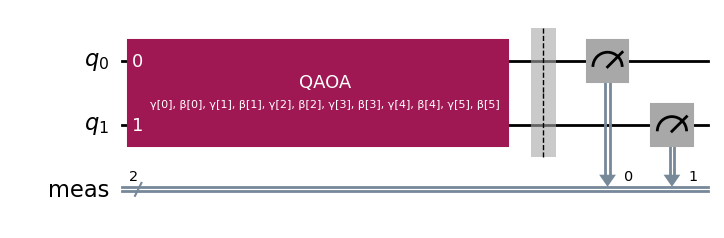

In [248]:
from qiskit.circuit.library import QAOAAnsatz
from qiskit.quantum_info import SparsePauliOp

circuit = QAOAAnsatz(cost_operator= ising_hamiltonian , reps= 6 , mixer_operator= None)
ZZ = SparsePauliOp('ZZZZZZ')
#circuit = QAOAAnsatz(cost_operator= ising_hamiltonian , reps= 5 , mixer_operator= xy_mixer_circuit(n))
#circuit = QAOAAnsatz(cost_operator= ising_hamiltonian , reps= 5 , mixer_operator= ZZ)
circuit.measure_all()

circuit.draw('mpl' , fold = False , scale = 1 , idle_wires = False)


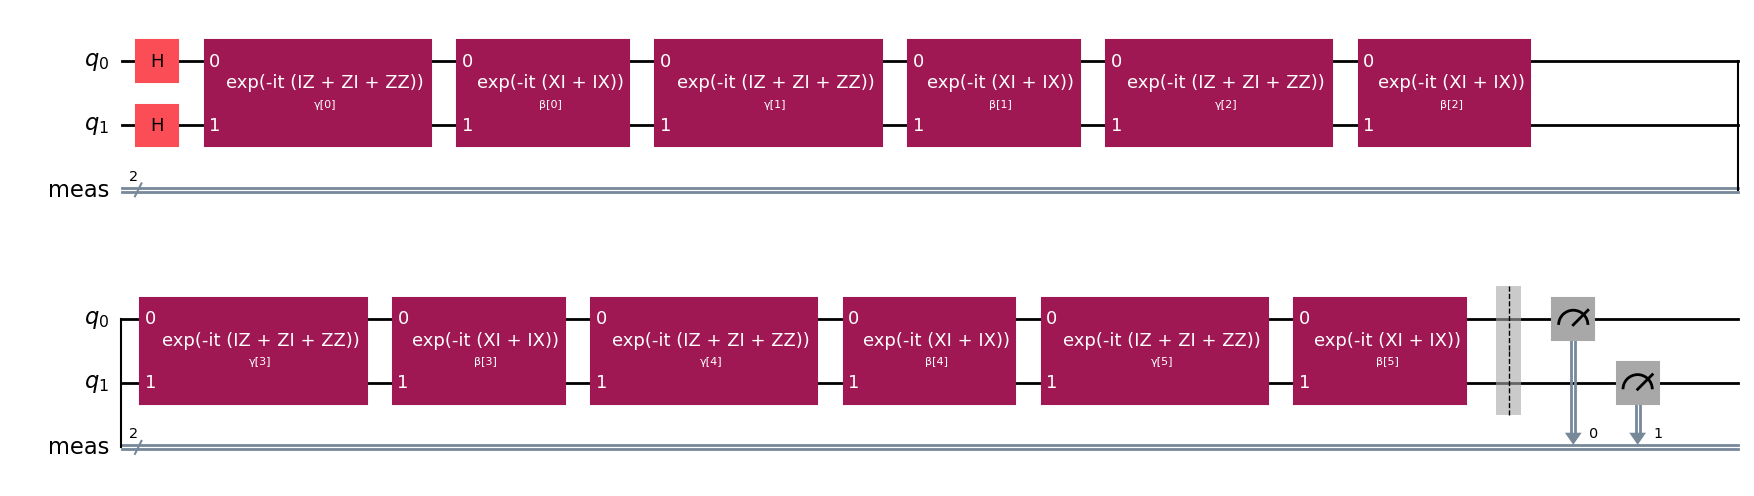

In [249]:
circuit.decompose().draw('mpl')

In [250]:
circuit.depth()

2

In [251]:
len(circuit.parameters)

12

In [252]:
from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit_aer import AerSimulator
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager

service = QiskitRuntimeService()
backend = service.backend("ibm_sherbrooke")
#aer = AerSimulator.from_backend(backend)
aer = AerSimulator()

#Create pass manager for transpilation
pm = generate_preset_pass_manager(optimization_level=3 , backend=aer)
hardware_circuit = pm.run(circuit)
#hardware_circuit.draw('mpl' , fold = False , scale = 0.5 , idle_wires=False)

In [253]:
initial_gamma = np.pi
initial_beta = np.pi
init_params = np.random.uniform(0 , np.pi , 12)

In [254]:
len(init_params)

12

In [255]:
def cost_func_estimator(params , ansatz , hamiltonian ,  estimator):

    # transform the observable defined on virtual qubits to 
    # an observable defined on all physical qubits
    isa_hamiltonian = hamiltonian.apply_layout(ansatz.layout)

    pub = (ansatz , isa_hamiltonian , params)
    job = estimator.run([pub])

    results = job.result()[0]
    cost = results.data.evs

    objective_func_vals.append(cost)

    return cost

In [256]:
from qiskit_ibm_runtime import Session , EstimatorV2 as Estimator
from scipy.optimize import minimize

objective_func_vals = [] # Global variable

with Session(backend=aer) as session:
    # If using qiskit-ibm-runtime<0.24.0 , change 'mode=' to 'session='
    estimator = Estimator(session= session)
    #estimator.options.default_shots = 1000

    # Set simple error suppresion / mitigation options
    # estimator.options.dynamical_decoupling.enable = True
    # estimator.options.dynamical_decoupling.sequence_type = "XY4"
    # estimator.options.twirling.enable_gates = True
    # estimator.options.twirling.num_randomizations = "auto"

    result = minimize(
        cost_func_estimator , 
        init_params,
        args = (hardware_circuit , ising_hamiltonian , estimator),
        method = "COBYLA",
        tol=1e-2
        
    )
    print(result)

c:\Users\isaac\anaconda3\envs\qiskit_env\Lib\site-packages\qiskit_ibm_runtime\session.py:157: UserWarning: Session is not supported in local testing mode or when using a simulator.
  warnings.warn(


 message: Optimization terminated successfully.
 success: True
  status: 1
     fun: -8.280585931353833
       x: [ 2.057e+00  8.277e-01  1.939e+00  3.807e-03  7.871e-01
            2.833e+00  2.931e+00  1.929e+00  2.007e+00  1.588e+00
            2.303e+00  9.914e-02]
    nfev: 76
   maxcv: 0.0


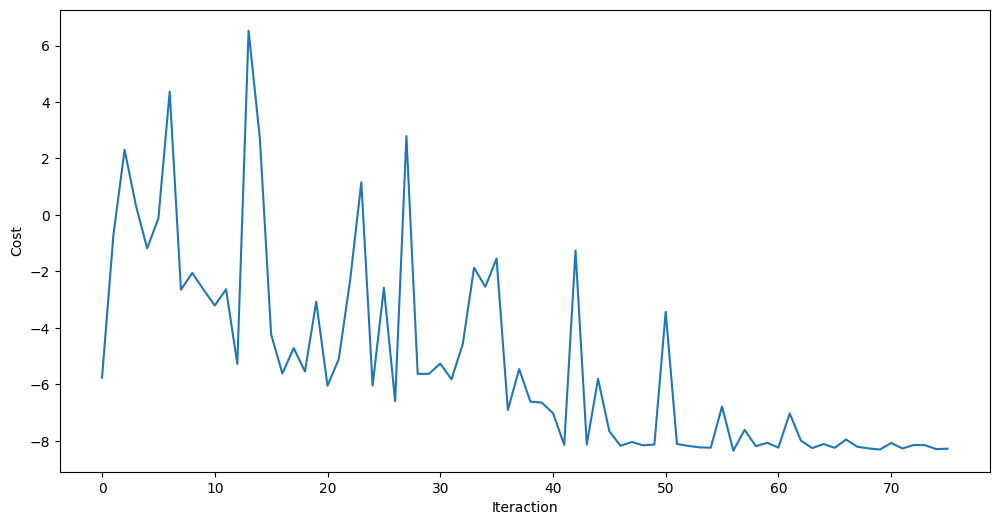

In [257]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,6))
plt.plot(objective_func_vals)
plt.xlabel("Iteraction")
plt.ylabel("Cost")
plt.show()

In [258]:
optimized_circuit = hardware_circuit.assign_parameters(result.x)
#optimized_circuit.draw('mpl' , fold = False , idle_wires = False)

In [259]:
from qiskit_ibm_runtime import SamplerV2 as Sampler
sampler = Sampler(backend = aer)
sampler.options.default_shots = 10000

# Set simple error suppresion/mitigation options
# sampler.options.dynamical_decoupling.enable = True
# sampler.options.dynamical_decoupling.sequence_type = "XY4"
# sampler.options.twirling.enable_gates  = True
# sampler.options.twirling.num_randomizations = "auto"

pub = (optimized_circuit , )
job = sampler.run([pub] , shots = int(1e4))
counts_int = job.result()[0].data.meas.get_int_counts()
counts_bin = job.result()[0].data.meas.get_counts()

shots = sum(counts_int.values())
final_distribution_int = {key: val/shots for key, val in counts_int.items()}
final_distribution_bin = {key: val/shots for key, val in counts_bin.items()}


def reverse_bitstring(bitstring):
    return bitstring[::-1]

eversed_dict_bin = {reverse_bitstring(key): value for key, value in final_distribution_bin.items()}
print(eversed_dict_bin)

{'10': 0.96, '01': 0.0178, '11': 0.0168, '00': 0.0054}


In [260]:
# Sort by values and get the 3 largest key-value pairs
top_5 = dict(sorted(eversed_dict_bin.items(), key=lambda item: item[1], reverse=True)[:5])

print(top_5)

{'10': 0.96, '01': 0.0178, '11': 0.0168, '00': 0.0054}


### Brute force test

In [261]:
def objective_func_square(x_list  , n):
    d_prime = 0
    d_1 =0
    d_2 = 0
    d_3 = 0
    for s in range(3):
        w = 0
        for i in range(n):
            w = w + data_list_frmt[i][s]*(2*x_list[i] - 1)
        w = (w/n)**2
        d_1 = d_1 + w

    for s in range(3):
        w = 0
        for i in range(n):
            w = w + (data_list_frmt[i][s]**2)*(2*x_list[i] - 1)
        w = (w/n)**2
        d_2 = d_2 + w
    d_2 = rho*d_2

    for s in range(3):
        for s_p in range(s , 3):
            w = 0
            for i in range(n):
                w = w + (data_list_frmt[i][s]*data_list_frmt[i][s_p])*(2*x_list[i] - 1)
            w = (w/n)**2
            d_3 = d_3 + w
    d_3 = 2*rho*d_2

    d_prime = d_1 + d_2 + d_3
    return (d_prime/1)
    

def objective_func(x_list  , n):
    d = 0
    d_1 =0
    d_2 = 0
    d_3 = 0
    for s in range(3):
        w = 0
        for i in range(n):
            w = w + data_list_frmt[i][s]*(2*x_list[i] - 1)
        w = np.abs(w/n)
        d_1 = d_1 + w

    for s in range(3):
        w = 0
        for i in range(n):
            w = w + (data_list_frmt[i][s]**2)*(2*x_list[i] - 1)
        w = np.abs(w/n)
        d_2 = d_2 + w
    d_2 = rho*d_2

    for s in range(3):
        for s_p in range(s , 3):
            w = 0
            for i in range(n):
                w = w + (data_list_frmt[i][s]*data_list_frmt[i][s_p])*(2*x_list[i] - 1)
            w = np.abs(w/n)
            d_3 = d_3 + w
    d_3 = 2*rho*d_2

    d = d_1 + d_3 + d_3
    return d
    

In [262]:
import itertools
list_test = [n]

# Loop over different values of M
for M in list_test:
    poss_list = list(itertools.product([0, 1], repeat=M))  # List of all binary combinations
    d_min = 1e100  # Initialization of the minimum value for the first function
    d_min_square = 1e100  # Initialization of the minimum value for the second function
    best_x = None  # To store the best solution for the first function
    best_x_square = None  # To store the best solution for the second function

    # Loop over all possible binary combinations
    for x in poss_list:
        if sum(x) == M / 2:  # Condition on the sum of elements in x
            if x[0] == 1:  # Condition on the first element of x
                # Calculating the values of the functions
                d = objective_func(x, M)
                d_square = objective_func_square(x, M)

                # Updating the best value for the first function
                if d < d_min:
                    d_min = d
                    best_x = x

                # Updating the best value for the second function
                if d_square < d_min_square:
                    d_min_square = d_square
                    best_x_square = x

    # Displaying the results
    print(f"M = {M}:")
    print(f"Minimum value (func1, func2): ({d_min}, {d_min_square})")
    print(f"Best x (func1, func2): ({best_x}, {best_x_square})")
    print("-" * 50)


M = 2:
Minimum value (func1, func2): (25868763.704886556, 669038144399537.5)
Best x (func1, func2): ((1, 0), (1, 0))
--------------------------------------------------


## Conclusion

Solving an optimization problem on quantum hardware requires considering several aspects. One of the first is the formulation of the problem to suit the quantum architecture. In our case, the problem as originally defined was not a quadratic optimization problem. Therefore, we started by reformulating the problem through a change of variables in order to obtain a quadratic version. However, this transformation significantly increased the number of qubits required to solve the problem.

In a second approach, we chose a different formulation, which involved replacing the absolute value with a square. This modification allowed us to maintain the same number of variables as with the absolute value, while preserving the same optimal solution. However, this solution has the drawback of requiring interactions between all qubits.

During the execution of the QAOA algorithm, we found that, in theory, it is possible to optimize up to 100 qubits. However, the process of searching for the parameters of the cost Hamiltonian and the mixer requires substantial computational power. On my personal computer, I cannot exceed 16 qubits at this stage, even though I have access to a machine with 127 qubits.

In summary, I did not obtain a clear or decisive solution when implementing the QAOA algorithm, even with very small instances of the problem, which I find personally strange.

One possible improvement would be the use of an **XY-mixer**, as described in the paper ["From the Quantum Approximate Optimization Algorithm to a Quantum Alternating Operator Ansatz"](https://arxiv.org/abs/1709.03489). 

Moreover, we could also consider using an approach based on quantum annealing.